# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Fake Job Detection using NLP</p>

##  <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Goal: Detecting Fake Job Postings posted in the different job portals</p>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Import Libraries </p>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import string

from collections import Counter
from nltk.corpus import stopwords

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from nltk.corpus import opinion_lexicon
from concurrent.futures import ProcessPoolExecutor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix,roc_curve,auc,roc_auc_score, ConfusionMatrixDisplay)

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Load Data from the Source </p>

In [57]:
df_raw = pd.read_csv("/kaggle/input/model-data/fake_job_postings - existing.csv")
print(f"Raw Data Shape: {df_raw.shape}")
df_raw.head()

Raw Data Shape: (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [58]:
df = df_raw.copy()

print(f"Shape: {df.shape}")

Shape: (17880, 18)


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Basic Data Exploration </p>

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [60]:
df.describe(include = "all")

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,17880.000000,17880,17534,6333,2868,14572,17879,15184,10668,17880.000000,17880.000000,17880.000000,14409,10830,9775,12977,11425,17880.000000
unique,NaN,11231,3105,1337,874,1709,14801,11967,6204,NaN,NaN,NaN,5,7,13,131,37,NaN
top,NaN,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,NaN,NaN,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,NaN
freq,NaN,311,718,551,142,726,379,410,726,NaN,NaN,NaN,11620,3809,5145,1734,1749,NaN
mean,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042897,0.795302,0.491723,NaN,NaN,NaN,NaN,NaN,0.048434
std,5161.655742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202631,0.403492,0.499945,NaN,NaN,NaN,NaN,NaN,0.214688
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,4470.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,13410.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [61]:
df.describe(exclude="object")

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
df.describe(exclude=np.number)

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
count,17880,17534,6333,2868,14572,17879,15184,10668,14409,10830,9775,12977,11425
unique,11231,3105,1337,874,1709,14801,11967,6204,5,7,13,131,37
top,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
freq,311,718,551,142,726,379,410,726,11620,3809,5145,1734,1749


There are many missing feature values, we will perform futhur checks

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">Data Checks to perform </p>
 - Check Missing values
 - Check Duplicates
 - Check data type
 - Check the number of unique values of each column
 - Check statistics of data set
 - Check various categories present in the different categorical column

 #### Missing values

In [63]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [64]:
## Here we will check the percentage of nan values present in each feature
feature_na = [feature for feature in df.columns if df[feature].isnull().sum() > 0 ]

for feature in feature_na:
    print(feature, np.round(df[feature].isnull().mean() * 100,4), " % missing")

location 1.9351  % missing
department 64.5805  % missing
salary_range 83.9597  % missing
company_profile 18.5011  % missing
description 0.0056  % missing
requirements 15.0783  % missing
benefits 40.3356  % missing
employment_type 19.4128  % missing
required_experience 39.4295  % missing
required_education 45.33  % missing
industry 27.4217  % missing
function 36.1018  % missing


In [65]:
# Null valuse more than 10%
columns_with_null_values_total = (df.isnull().sum() / len(df)) * 100
columns_with_null_values_percentage = columns_with_null_values_total[columns_with_null_values_total > 10].sort_values(ascending=False)

columns_with_null_values_percentage

salary_range           83.959732
department             64.580537
required_education     45.329978
benefits               40.335570
required_experience    39.429530
function               36.101790
industry               27.421700
employment_type        19.412752
company_profile        18.501119
requirements           15.078300
dtype: float64

<b>observation:</b> There are many missing feature values. There 8 features with ~85% values are null and 2 features with ~65% null.

The feature with 50% null values can be removed from the dataset

In [66]:
df.drop(columns_with_null_values_percentage.keys().tolist(),axis=1,inplace=True)

df.head()

,job_id,title,location,description,telecommuting,has_company_logo,has_questions,fraudulent
0,1,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",0,1,0,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,0,1,0,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",0,1,0,0
3,4,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,0,1,0,0
4,5,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,0,1,1,0


In [67]:
df.columns

Index(['job_id', 'title', 'location', 'description', 'telecommuting',
       'has_company_logo', 'has_questions', 'fraudulent'],
      dtype='object')

In [68]:
df.drop(columns=['job_id','telecommuting','has_company_logo','has_questions'],inplace = True)

In [69]:
df.rename(columns={'title':'role','description':'job_description'},inplace=True)

In [70]:
df.head()

,role,location,job_description,fraudulent
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",0
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,0
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,0


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Duplicate Values Check </p>

In [71]:
df.duplicated().sum()

512

In [72]:
print("***** Duplicate check Feature wise *****\n")

# Check Job description duplications
print("job_description: ", df["job_description"].duplicated().sum())

***** Duplicate check Feature wise *****

job_description:  3078


There are duplicated records, this has to taken care during preprocessing stage

In [73]:
#Sorting data according to text in ascending order
sorted_data=df.sort_values('job_description', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_data[sorted_data["job_description"].duplicated()]

,role,location,job_description,fraudulent
14118,Experienced Dog Groomer - Costa Mesa,"US, CA, Costa Mesa","""Pride is a personal commitment. It is an att...",0
12007,EXPERIENCED CAREGIVERS NEEDED TODAY!THE BEST P...,"US, CO, Denver","""We take great care of our CarePartners so the...",0
11806,EXPERIENCED CAREGIVERS NEEDED TODAY!THE BEST P...,"US, CO, denver","""We take great care of our CarePartners so the...",0
3030,mobile apps for Android/iOS developer,"VN, 64,",#NAME?,0
3951,Senior Java Developer with Hadoop Exp,"US, OH, Dublin",#NAME?,0
...,...,...,...,...
13398,Super Marketing Specialist,"CA, ON, Toronto",“What do you want to be when you grow up?” you...,0
13402,Super Marketing Specialist,"CA, ON, Toronto",“What do you want to be when you grow up?” you...,0
1823,Data Entry,"US, WA, ARDENVOIR WA",•Prepares source data for computer entry by co...,0
9992,Inbound Sales Representatives,"US, NY, Farmingdale",• Answering incoming calls and securing ord...,0


In [74]:
df.shape

(17880, 4)

#### Check the Feature Uniqueness

In [75]:
for feature in df.columns:
    print('{}: Unique Count: {}\n {}\n'.format(feature, len(df[feature].unique()), df[feature].unique()))

role: Unique Count: 11231
 ['Marketing Intern' 'Customer Service - Cloud Video Production'
 'Commissioning Machinery Assistant (CMA)' ...
 'Senior Financial Analyst (Retail) ' 'Account Director - Distribution '
 'Project Cost Control Staff Engineer - Cost Control Exp - TX']

location: Unique Count: 3106
 ['US, NY, New York' 'NZ, , Auckland' 'US, IA, Wever' ...
 'US, CA, los Angeles' 'CA, , Ottawa' 'GB, WSX, Chichester']

job_description: Unique Count: 14802
 ['Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssist

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Data preprocessing </p>

<b>Handle Missing Values</b>

In [76]:
df.isnull().sum()

role                 0
location           346
job_description      1
fraudulent           0
dtype: int64

In [77]:
# Fill na values with missing

for feature in df.columns:
  if(df[feature].isnull().sum()>0):
    df[feature].fillna("missing", inplace=True)

df.isnull().sum()

role               0
location           0
job_description    0
fraudulent         0
dtype: int64

<b>Deduplication of data</b>

In [78]:
df.duplicated().sum()

512

In [79]:
df.drop_duplicates(keep="first", inplace= True)
print("Shape: ", df.shape)

df.duplicated().sum()

Shape:  (17368, 4)


0

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Exploratory Data Analysis </p>

#### Description: Analyze the count of Charecters, Words, and Sentences in each segment

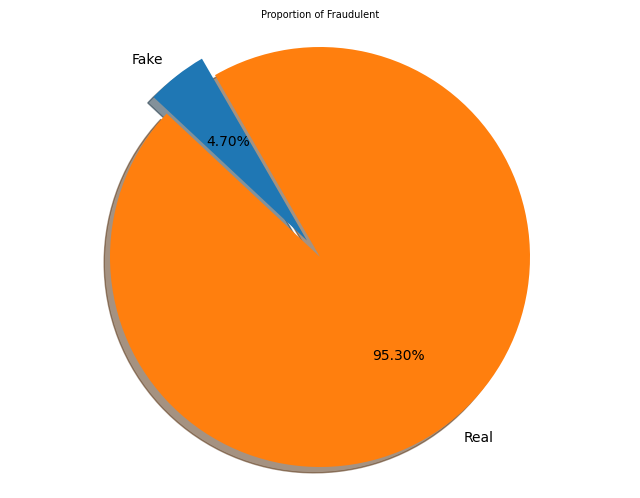

In [80]:
 # Checking for distribution of class label(percentages belonging to real class and percentages belonging to fraud class)
 # in the data 1 indicates fraud post
 # 0 indicating real post
 # Plotting pie chart for the data
 # function of Explode function: how the portion will appear (to understand change explode=(0,0.5))

labels = 'Fake', 'Real'
sizes = [df.fraudulent[df['fraudulent']== 1].count(), df.fraudulent[df['fraudulent']== 0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6)) #size of the pie chart
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=120) #autopct %1.2f%% for 2 digit precision
ax1.axis('equal')
plt.title("Proportion of Fraudulent", size = 7)
plt.show()

In [81]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [82]:
# No. of charecters in Job Description
df['desc_num_char'] = df['job_description'].apply(len)

# No. of of words in Job Description
df['desc_num_words'] = df['job_description'].apply(lambda x:len(nltk.word_tokenize(x)))

# No. of of sentences in Job Description
df['desc_num_sent'] = df['job_description'].apply(lambda x:len(nltk.sent_tokenize(x)))

df.head()

,role,location,job_description,fraudulent,desc_num_char,desc_num_words,desc_num_sent
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",0,905,139,1
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,0,2077,359,15
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",0,355,57,3
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,0,2600,384,6
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,0,1520,203,2


In [83]:
df.describe(include=np.number)

,fraudulent,desc_num_char,desc_num_words,desc_num_sent
count,17368.000000,17368.000000,17368.000000,17368.000000
mean,0.046983,1212.639855,193.463151,5.164152
std,0.211608,894.430544,140.626763,4.330857
min,0.000000,6.000000,0.000000,0.000000
25%,0.000000,601.000000,97.000000,2.000000
50%,0.000000,1011.000000,164.000000,4.000000
75%,0.000000,1581.000000,253.000000,7.000000
max,1.000000,14907.000000,2448.000000,85.000000


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Text preprocessing </p>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative type

In [84]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopWords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [85]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess(corpus):
    preprocessed = []
    for sentance in tqdm(corpus):
        #sentance = re.sub(r"http+", "", sentance)
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopWords)
        #sentence = ' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english'))
        #preprocessed.append(sentance.strip())
        preprocessed.append(' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english')))

    return preprocessed

In [86]:
df.sample(5)

,role,location,job_description,fraudulent,desc_num_char,desc_num_words,desc_num_sent
2145,Product Designer,"US, CA, Palo Alto",We are a small team working to engineer the pe...,0,1802,315,9
12526,Senior Project Manager (Software),"NZ, N, Auckland",We are a driven and ambitious technology busin...,0,996,159,5
172,Registrar's in Psychiatry,"AU, QLD, Brisbane",We are seeking Registrar's in Psychiatry for a...,0,101,25,1
16442,Fulfillment Associate,"US, GA, Athens",We are looking for new members to join our fas...,0,1304,257,9
13484,Training Administrator,"US, FL, Jacksonville",Key Responsibilities ...,0,6877,369,25


In [87]:
df.dtypes

role               object
location           object
job_description    object
fraudulent          int64
desc_num_char       int64
desc_num_words      int64
desc_num_sent       int64
dtype: object

In [88]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [89]:
%%time

df["desc_transformed"] = preprocess(df['job_description'].values)
#df["site_transformed"] = preprocess(df['site'].values)
#df["role_transformed"] = preprocess(df['role'].values)
#df["comp_transformed"] = preprocess(df['company_name'].values)
#df["loc_transformed"] = preprocess(df['location'].values)


df["desc_transformed"][:5]

100%|██████████| 17368/17368 [08:13<00:00, 35.17it/s]

CPU times: user 7min 15s, sys: 59 s, total: 8min 14s
Wall time: 8min 13s


0    fast growing james beard award winning online ...
1    organised focused vibrant awesome passion cust...
2    client located houston actively seeking experi...
3    company esri environmental systems research in...
4    job title itemization review managerlocation f...
Name: desc_transformed, dtype: object

In [90]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [91]:
# we will plot 3 kind of word cloud
# 1st we will visualize all the words our data using the wordcloud plot
# 2nd we will visualize common words in real job posting
# 3rd we will visualize common words in fraud job posting
# join function is a core python function

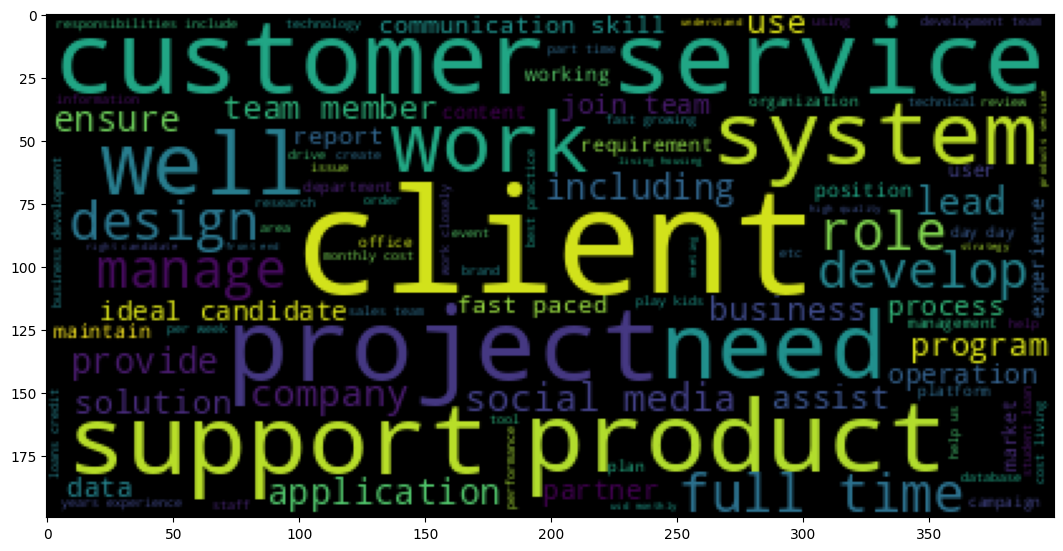

In [92]:
# Extract the text from DataFrame
desc_text_data = df['desc_transformed'].str.cat(sep=" ")

# Generate the word cloud
wc = WordCloud()
desc_post = wc.generate(desc_text_data)

# Plot the word cloud
plt.figure(figsize=(13, 8))
plt.imshow(desc_post)
plt.show()

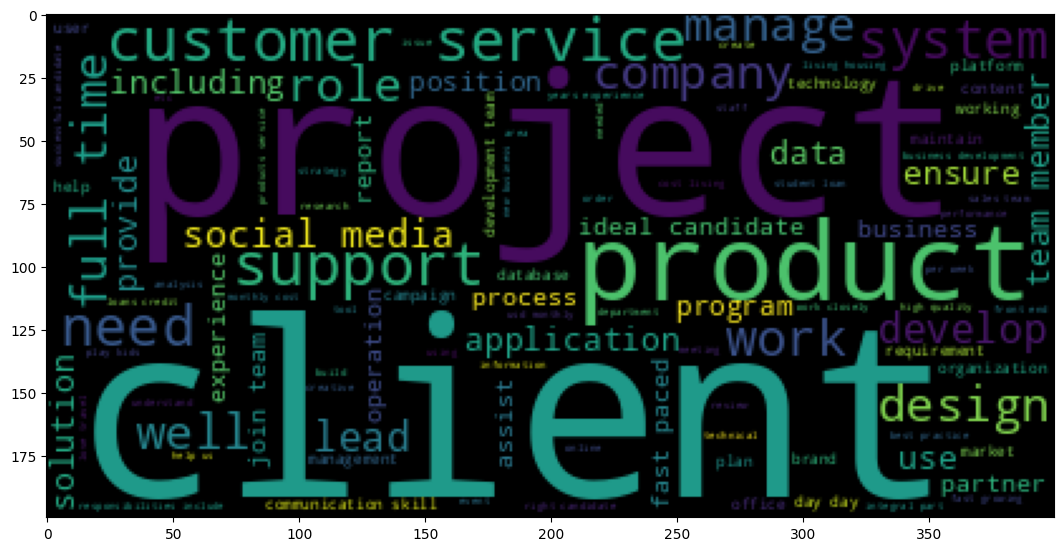

In [93]:
# Extract the real post text from DataFrame
real_post_text_data = df[df['fraudulent']==0]['desc_transformed'].str.cat(sep=" ")

# Generate the word cloud
wc = WordCloud()
real_post = wc.generate(real_post_text_data)

# Plot the word cloud
plt.figure(figsize=(13, 8))
plt.imshow(real_post)
plt.show()

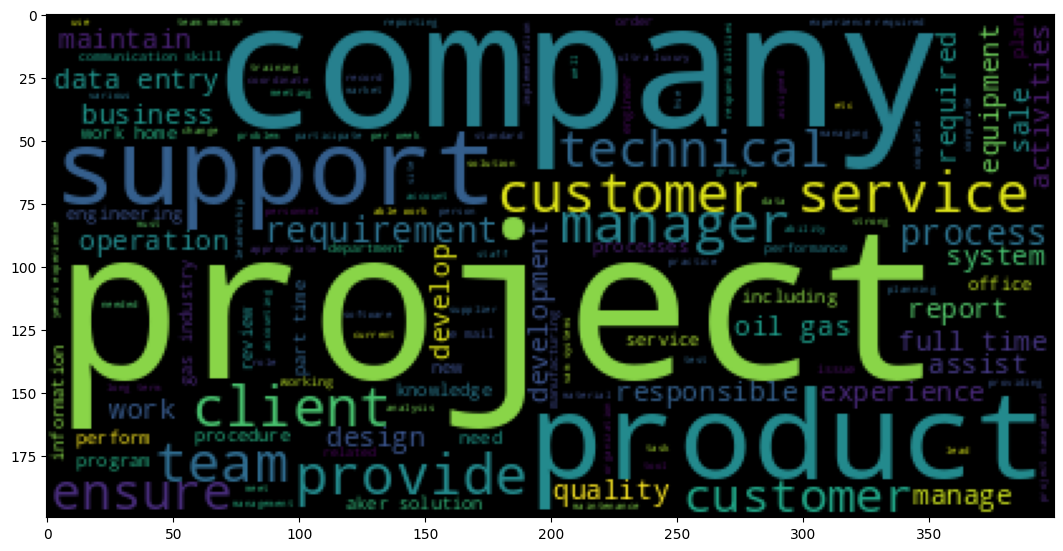

In [94]:
# Extract the fraud post text from DataFrame
fraud_post_text_data = df[df['fraudulent']==1]['desc_transformed'].str.cat(sep=" ")

# Generate the word cloud
wc = WordCloud()
fraud_post = wc.generate(fraud_post_text_data)

# Plot the word cloud
plt.figure(figsize=(13, 8))
plt.imshow(fraud_post)
plt.show()

In [95]:
df.fraudulent.value_counts()

fraudulent
0    16552
1      816
Name: count, dtype: int64

<b>Extract the Opinin from the Lexicon Lib</b>

In [96]:
# Download the lexicon
nltk.download('opinion_lexicon')

[nltk_data] Error loading opinion_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [97]:
# Get positive and negative words from the lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [98]:
# Positive and negative word count for desc
# Tokenize your desc_text_data
tokens = word_tokenize(desc_text_data)

# Calculate sentiment score
positive_score = sum(word in positive_words for word in tokens)
negative_score = sum(word in negative_words for word in tokens)

# Print the sentiment scores
print("Positive Score:", positive_score)
print("Negative Score:", negative_score)

Positive Score: 168141
Negative Score: 23687


In [99]:
# Positive and negative word count for real_post
# Tokenize your real_post_text_data
tokens = word_tokenize(real_post_text_data)

# Calculate sentiment score
positive_score = sum(word in positive_words for word in tokens)
negative_score = sum(word in negative_words for word in tokens)

# Print the sentiment scores
print("Positive Score:", positive_score)
print("Negative Score:", negative_score)

Positive Score: 161376
Negative Score: 22668


In [100]:
# Positive and negative word count for fraud_post
# Tokenize your fraud_post_text_data
tokens = word_tokenize(fraud_post_text_data)

# Calculate sentiment score
positive_score = sum(word in positive_words for word in tokens)
negative_score = sum(word in negative_words for word in tokens)

# Print the sentiment scores
print("Positive Score:", positive_score)
print("Negative Score:", negative_score)

Positive Score: 6765
Negative Score: 1019


In [101]:
%%time
#OPTIMIZED
# Assuming you have a DataFrame named df with a column 'desc_transformed'
data_for_parallel = df[['desc_transformed']].copy()


# Function to calculate sentiment scores for a single row
def calculate_sentiment_scores(row):
    tokens = word_tokenize(row['desc_transformed'])
    positive_score = np.sum(np.isin(tokens, list(positive_words)))
    negative_score = np.sum(np.isin(tokens, list(negative_words)))
    return positive_score, negative_score

# Convert Pandas DataFrame to a list of dictionaries
data_for_parallel = data_for_parallel.to_dict('records')

# Calculate sentiment scores using GPU and parallelization
with ProcessPoolExecutor() as executor:
    sentiment_scores = list(executor.map(calculate_sentiment_scores, data_for_parallel))

# Assign sentiment scores to the DataFrame
df[['positive_score', 'negative_score']] = np.array(sentiment_scores)

# Display the DataFrame with new sentiment score columns
print(df[['desc_transformed', 'positive_score', 'negative_score']])

                                        desc_transformed  positive_score  \
0      fast growing james beard award winning online ...               7   
1      organised focused vibrant awesome passion cust...              22   
2      client located houston actively seeking experi...               3   
3      company esri environmental systems research in...              19   
4      job title itemization review managerlocation f...               5   
...                                                  ...             ...   
17875  case first time visited website vend award win...              15   
17876  payroll accountant focus primarily payroll fun...               9   
17877  experienced project cost control staff enginee...              13   
17878  nemsia studios looking experienced visual grap...               3   
17879  vend award winning web based point sale softwa...              24   

       negative_score  
0                   1  
1                   7  
2              

In [102]:
df.head()

,role,location,job_description,fraudulent,desc_num_char,desc_num_words,desc_num_sent,desc_transformed,positive_score,negative_score
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",0,905,139,1,fast growing james beard award winning online ...,7,1
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,0,2077,359,15,organised focused vibrant awesome passion cust...,22,7
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",0,355,57,3,client located houston actively seeking experi...,3,0
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,0,2600,384,6,company esri environmental systems research in...,19,3
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,0,1520,203,2,job title itemization review managerlocation f...,5,4


In [103]:
df_score=df.copy()

In [104]:
df_score.to_csv("Existing_data_score.csv", index=False)

In [105]:
df = pd.read_csv("/kaggle/input/model-data/Existing_data_score.csv")

In [106]:
df.head()

,role,location,job_description,fraudulent,desc_num_char,desc_num_words,desc_num_sent,desc_transformed,positive_score,negative_score
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",0,905,139,1,fast growing james beard award winning online ...,7,1
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,0,2077,359,15,organised focused vibrant awesome passion cust...,22,7
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",0,355,57,3,client located houston actively seeking experi...,3,0
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,0,2600,384,6,company esri environmental systems research in...,19,3
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,0,1520,203,2,job title itemization review managerlocation f...,5,4


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17368 entries, 0 to 17367
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              17368 non-null  object
 1   location          17368 non-null  object
 2   job_description   17368 non-null  object
 3   fraudulent        17368 non-null  int64 
 4   desc_num_char     17368 non-null  int64 
 5   desc_num_words    17368 non-null  int64 
 6   desc_num_sent     17368 non-null  int64 
 7   desc_transformed  17367 non-null  object
 8   positive_score    17368 non-null  int64 
 9   negative_score    17368 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 1.3+ MB


In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Specify the size for the training set (e.g., 80%)
train_size = 0.8

# Split the data into training and testing sets
df_train, df_test = train_test_split(df, test_size=1 - train_size, random_state=42)

# Save the DataFrames to separate CSV files
df_train.to_csv('train_data.csv', index=False)
df_test.to_csv('test_data.csv', index=False)


In [109]:
df = df_train.copy()

print(f"Shape: {df.shape}")

Shape: (13894, 10)


In [110]:
df['fraudulent'].value_counts()

fraudulent
0    13230
1      664
Name: count, dtype: int64

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">Model Building </p>

In [111]:
# Fill missing value in 'desc_transformed' with an empty string
df['desc_transformed'].fillna('', inplace=True)

In [112]:
#MODEL BUILDING USING EXISTING DATA - XGBOOST
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBClassifier
import numpy as np

# Assuming df has 'desc_transformed', 'positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent', 'fraudulent' columns
# If needed, fill any missing values in df
df = df.fillna('')

# Extract features and labels
X_text = df['desc_transformed']
X_numeric = df[['positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent']]
y = df['fraudulent']

# Split the data into training and testing sets
X_text_train, X_text_test, X_numeric_train, X_numeric_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

# TF-IDF vectorization for text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = tfidf_vectorizer.transform(X_text_test)

# Combine text TF-IDF vectors with numeric features
X_train_combined = pd.concat([
    X_numeric_train.reset_index(drop=True),
    pd.DataFrame(X_text_train_tfidf.toarray())
], axis=1)

X_test_combined = pd.concat([
    X_numeric_test.reset_index(drop=True),
    pd.DataFrame(X_text_test_tfidf.toarray())
], axis=1)

# Standardize numeric features
scaler = StandardScaler()
X_train_combined.iloc[:, :5] = scaler.fit_transform(X_train_combined.iloc[:, :5])
X_test_combined.iloc[:, :5] = scaler.transform(X_test_combined.iloc[:, :5])

# Identify numeric columns
numeric_columns = ['positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent']

# Apply Min-Max scaling to numeric features
min_max_scaler = MinMaxScaler()
X_train_combined[numeric_columns] = min_max_scaler.fit_transform(X_train_combined[numeric_columns])
X_test_combined[numeric_columns] = min_max_scaler.transform(X_test_combined[numeric_columns])

# Convert feature names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_combined, y_train = smote.fit_resample(X_train_combined, y_train)

# Define XGBoost model
xgb = XGBClassifier(n_estimators=50, random_state=42)

# Define KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to store metrics for each fold
all_y_true = []
all_y_pred = []

# Define custom threshold
custom_threshold = 0.35  # Adjust this threshold based on your requirements

# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train_combined), 1):
    X_train, X_val = X_train_combined.iloc[train_index], X_train_combined.iloc[val_index]
    y_train_batch, y_val_batch = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the XGBoost model
    xgb.fit(X_train, y_train_batch)

    # Predict probabilities
    y_pred_prob_val = xgb.predict_proba(X_val)[:, 1]

    # Apply custom threshold
    y_pred_val = (y_pred_prob_val > custom_threshold).astype(int)

    # Store true and predicted labels for each fold
    all_y_true.extend(y_val_batch)
    all_y_pred.extend(y_pred_val)

    # Optionally, print metrics for each fold
    print(f"Fold {fold} - Accuracy: {accuracy_score(y_val_batch, y_pred_val)}, Precision: {precision_score(y_val_batch, y_pred_val)}, Recall: {recall_score(y_val_batch, y_pred_val)}, F1: {f1_score(y_val_batch, y_pred_val)}")

# Evaluate on the test set
# Predict probabilities
y_pred_prob_test = xgb.predict_proba(X_test_combined)[:, 1]

# Apply custom threshold
y_pred_test = (y_pred_prob_test > custom_threshold).astype(int)

# Print metrics for the test set
print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision: {precision_score(y_test, y_pred_test)}")
print(f"Recall: {recall_score(y_test, y_pred_test)}")
print(f"F1: {f1_score(y_test, y_pred_test)}")

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("\nTest Set Confusion Matrix:")
print(conf_matrix_test)

# Classification report for the test set
classification_report_test = classification_report(y_test, y_pred_test, target_names=["Real", "Fake"])
print("\nTest Set Classification Report:")
print(classification_report_test)


Fold 1 - Accuracy: 0.9848842701936703, Precision: 0.9793621013133208, Recall: 0.9905123339658444, F1: 0.9849056603773586
Fold 2 - Accuracy: 0.9827586206896551, Precision: 0.9766888677450047, Recall: 0.9884448724121329, F1: 0.9825317061497966
Fold 3 - Accuracy: 0.9860651865847898, Precision: 0.9835240274599543, Recall: 0.9894106813996317, F1: 0.9864585724122102
Fold 4 - Accuracy: 0.9825183085282305, Precision: 0.9725768321513002, Recall: 0.9922817173178967, F1: 0.9823304680038205
Fold 5 - Accuracy: 0.9896054807465154, Precision: 0.9857274401473296, Recall: 0.9939647168059424, F1: 0.9898289412852519

Test Set Metrics:
Accuracy: 0.964735516372796
Precision: 0.6377952755905512
Recall: 0.6090225563909775
F1: 0.6230769230769231

Test Set Confusion Matrix:
[[2600   46]
 [  52   81]]

Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      2646
        Fake       0.64      0.61      0.62       133

    accuracy    

AUC Score: 0.9299637983848509


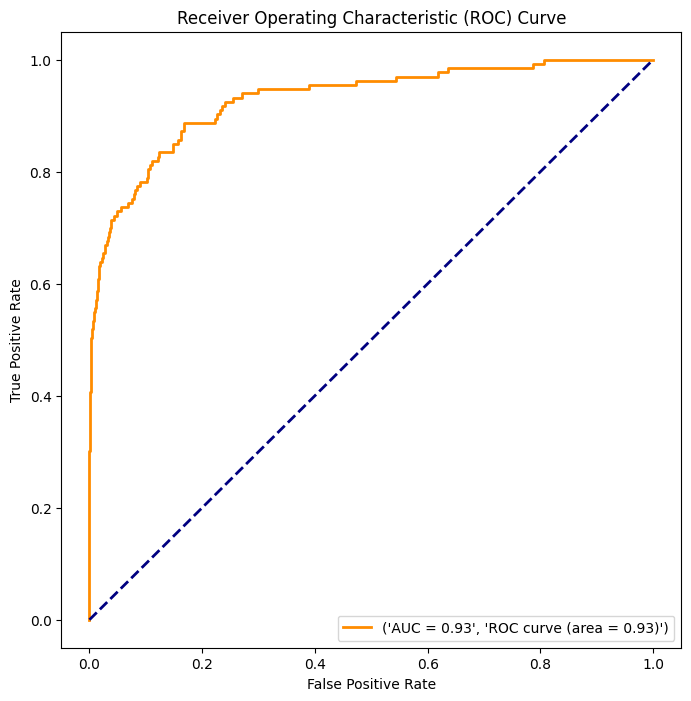

In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Predict probabilities for positive class
y_proba = xgb.predict_proba(X_test_combined)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=(f'AUC = {auc_score:.2f}','ROC curve (area = {:.2f})'.format(roc_auc)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [114]:
# MODEL BUILDING USING EXISTING DATA - RANDOM FOREST
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier  # Change import to RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
import numpy as np

# Assuming df has 'desc_transformed', 'positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent', 'fraudulent' columns
# If needed, fill any missing values in df
df = df.fillna('')

# Extract features and labels
X_text = df['desc_transformed']
X_numeric = df[['positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent']]
y = df['fraudulent']

# Split the data into training and testing sets
X_text_train, X_text_test, X_numeric_train, X_numeric_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

# TF-IDF vectorization for text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = tfidf_vectorizer.transform(X_text_test)

# Combine text TF-IDF vectors with numeric features
X_train_combined = pd.concat([
    X_numeric_train.reset_index(drop=True),
    pd.DataFrame(X_text_train_tfidf.toarray())
], axis=1)

X_test_combined = pd.concat([
    X_numeric_test.reset_index(drop=True),
    pd.DataFrame(X_text_test_tfidf.toarray())
], axis=1)

# Standardize numeric features
scaler = StandardScaler()
X_train_combined.iloc[:, :5] = scaler.fit_transform(X_train_combined.iloc[:, :5])
X_test_combined.iloc[:, :5] = scaler.transform(X_test_combined.iloc[:, :5])

# Identify numeric columns
numeric_columns = ['positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent']

# Apply Min-Max scaling to numeric features
min_max_scaler = MinMaxScaler()
X_train_combined[numeric_columns] = min_max_scaler.fit_transform(X_train_combined[numeric_columns])
X_test_combined[numeric_columns] = min_max_scaler.transform(X_test_combined[numeric_columns])

# Convert feature names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_combined, y_train = smote.fit_resample(X_train_combined, y_train)

# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Define KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to store metrics for each fold
all_y_true = []
all_y_pred = []

# Define custom threshold
custom_threshold = 0.35  # Adjust this threshold based on your requirements

# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train_combined), 1):
    X_train, X_val = X_train_combined.iloc[train_index], X_train_combined.iloc[val_index]
    y_train_batch, y_val_batch = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the Random Forest model
    rf_model.fit(X_train, y_train_batch)

    # Predict probabilities
    y_pred_prob_val = rf_model.predict_proba(X_val)[:, 1]

    # Apply custom threshold
    y_pred_val = (y_pred_prob_val > custom_threshold).astype(int)

    # Store true and predicted labels for each fold
    all_y_true.extend(y_val_batch)
    all_y_pred.extend(y_pred_val)

    # Optionally, print metrics for each fold
    print(f"Fold {fold} - Accuracy: {accuracy_score(y_val_batch, y_pred_val)}, Precision: {precision_score(y_val_batch, y_pred_val)}, Recall: {recall_score(y_val_batch, y_pred_val)}, F1: {f1_score(y_val_batch, y_pred_val)}")

# Evaluate on the test set
# Predict probabilities
y_pred_prob_test = rf_model.predict_proba(X_test_combined)[:, 1]

# Apply custom threshold
y_pred_test = (y_pred_prob_test > custom_threshold).astype(int)

# Print metrics for the test set
print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision: {precision_score(y_test, y_pred_test)}")
print(f"Recall: {recall_score(y_test, y_pred_test)}")
print(f"F1: {f1_score(y_test, y_pred_test)}")

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("\nTest Set Confusion Matrix:")
print(conf_matrix_test)

# Classification report for the test set
classification_report_test = classification_report(y_test, y_pred_test, target_names=["Real", "Fake"])
print("\nTest Set Classification Report:")
print(classification_report_test)


Fold 1 - Accuracy: 0.9936230514879546, Precision: 0.9891866478608369, Recall: 0.9981024667931688, F1: 0.9936245572609209
Fold 2 - Accuracy: 0.9978743504959848, Precision: 0.9956855225311602, Recall: 1.0, F1: 0.9978380975258228
Fold 3 - Accuracy: 0.9966934341048653, Precision: 0.9940476190476191, Recall: 0.9995395948434622, F1: 0.9967860422405878
Fold 4 - Accuracy: 0.9933853059296007, Precision: 0.9880668257756563, Recall: 0.9985528219971056, F1: 0.9932821497120922
Fold 5 - Accuracy: 0.9950389794472005, Precision: 0.9912482726853984, Recall: 0.9990714948932219, F1: 0.9951445086705203

Test Set Metrics:
Accuracy: 0.9697732997481109
Precision: 0.7207207207207207
Recall: 0.6015037593984962
F1: 0.6557377049180327

Test Set Confusion Matrix:
[[2615   31]
 [  53   80]]

Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.98      2646
        Fake       0.72      0.60      0.66       133

    accuracy                  

AUC Score: 0.9168485272137258


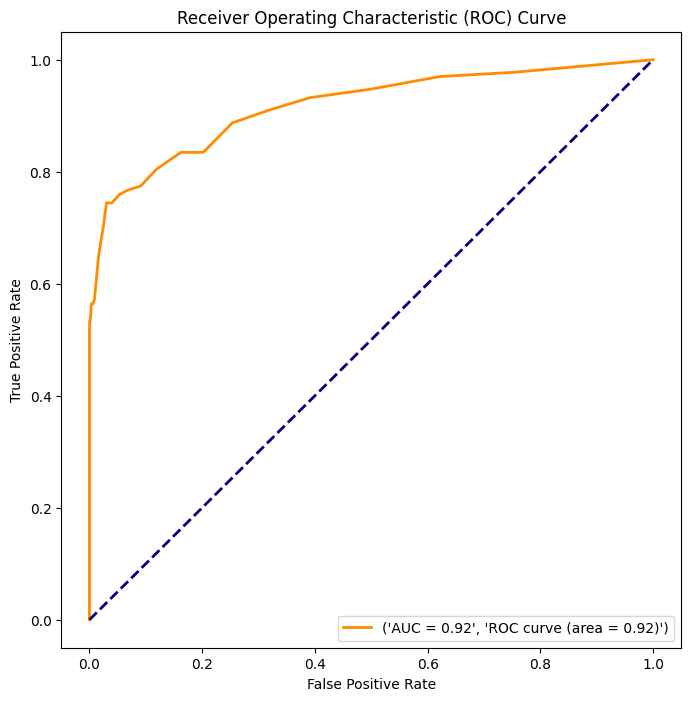

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Predict probabilities for positive class
y_proba = rf_model.predict_proba(X_test_combined)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=(f'AUC = {auc_score:.2f}','ROC curve (area = {:.2f})'.format(roc_auc)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [116]:
# Check class distribution in training set
print("Training Set Class Distribution:")
print(y_train.value_counts())

# Check class distribution in testing set
print("\nTesting Set Class Distribution:")
print(y_test.value_counts())


Training Set Class Distribution:
fraudulent
0    10584
1    10584
Name: count, dtype: int64

Testing Set Class Distribution:
fraudulent
0    2646
1     133
Name: count, dtype: int64


In [117]:
# Evaluate XGBoost on the test set
custom_threshold = 0.3
y_pred_prob_test_xgb = xgb.predict_proba(X_test_combined)[:, 1]
y_pred_test_xgb = (y_pred_prob_test_xgb > custom_threshold).astype(int)

# Print metrics for XGBoost
print("\nXGBoost Test Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_xgb)}")
print(f"Precision: {precision_score(y_test, y_pred_test_xgb)}")
print(f"Recall: {recall_score(y_test, y_pred_test_xgb)}")
print(f"F1: {f1_score(y_test, y_pred_test_xgb)}")

# Confusion matrix for XGBoost
conf_matrix_test_xgb = confusion_matrix(y_test, y_pred_test_xgb)
print("\nXGBoost Test Set Confusion Matrix:")
print(conf_matrix_test_xgb)

# Classification report for XGBoost
classification_report_test_xgb = classification_report(y_test, y_pred_test_xgb, target_names=["Real", "Fake"])
print("\nXGBoost Test Set Classification Report:")
print(classification_report_test_xgb)


# Evaluate Random Forest on the test set
y_pred_prob_test_rf = rf_model.predict_proba(X_test_combined)[:, 1]
y_pred_test_rf = (y_pred_prob_test_rf > custom_threshold).astype(int)

# Print metrics for Random Forest
print("\nRandom Forest Test Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_test_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_test_rf)}")
print(f"F1: {f1_score(y_test, y_pred_test_rf)}")

# Confusion matrix for Random Forest
conf_matrix_test_rf = confusion_matrix(y_test, y_pred_test_rf)
print("\nRandom Forest Test Set Confusion Matrix:")
print(conf_matrix_test_rf)

# Classification report for Random Forest
classification_report_test_rf = classification_report(y_test, y_pred_test_rf, target_names=["Real", "Fake"])
print("\nRandom Forest Test Set Classification Report:")
print(classification_report_test_rf)



XGBoost Test Set Metrics:
Accuracy: 0.9607772580064772
Precision: 0.58
Recall: 0.6541353383458647
F1: 0.6148409893992933

XGBoost Test Set Confusion Matrix:
[[2583   63]
 [  46   87]]

XGBoost Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      2646
        Fake       0.58      0.65      0.61       133

    accuracy                           0.96      2779
   macro avg       0.78      0.82      0.80      2779
weighted avg       0.96      0.96      0.96      2779


Random Forest Test Set Metrics:
Accuracy: 0.9650953580424613
Precision: 0.625
Recall: 0.6766917293233082
F1: 0.6498194945848375

Random Forest Test Set Confusion Matrix:
[[2592   54]
 [  43   90]]

Random Forest Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      2646
        Fake       0.62      0.68      0.65       133

    accuracy                          

In [118]:
#Ensemble model using Voting Classsifier
from sklearn.ensemble import VotingClassifier

# Create a VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('rf', rf_model)
], voting='soft')  # Use 'soft' for probability-based voting

# Train the ensemble model on the training data
ensemble_model.fit(X_train_combined, y_train)

# Predict probabilities for the test set
y_pred_prob_ensemble = ensemble_model.predict_proba(X_test_combined)[:, 1]

# Apply custom threshold
y_pred_ensemble = (y_pred_prob_ensemble > custom_threshold).astype(int)

# Print metrics for the ensemble model on the test set
print("\nEnsemble Model Test Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble)}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble)}")
print(f"Recall: {recall_score(y_test, y_pred_ensemble)}")
print(f"F1: {f1_score(y_test, y_pred_ensemble)}")

# Confusion matrix for the ensemble model
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print("\nEnsemble Model Test Set Confusion Matrix:")
print(conf_matrix_ensemble)

# Classification report for the ensemble model
classification_report_ensemble = classification_report(y_test, y_pred_ensemble, target_names=["Real", "Fake"])
print("\nEnsemble Model Test Set Classification Report:")
print(classification_report_ensemble)


Ensemble Model Test Set Metrics:
Accuracy: 0.9715725080964376
Precision: 0.717741935483871
Recall: 0.6691729323308271
F1: 0.6926070038910506

Ensemble Model Test Set Confusion Matrix:
[[2611   35]
 [  44   89]]

Ensemble Model Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      2646
        Fake       0.72      0.67      0.69       133

    accuracy                           0.97      2779
   macro avg       0.85      0.83      0.84      2779
weighted avg       0.97      0.97      0.97      2779




Ensemble Model Test Set ROC AUC: 0.9404392500525691


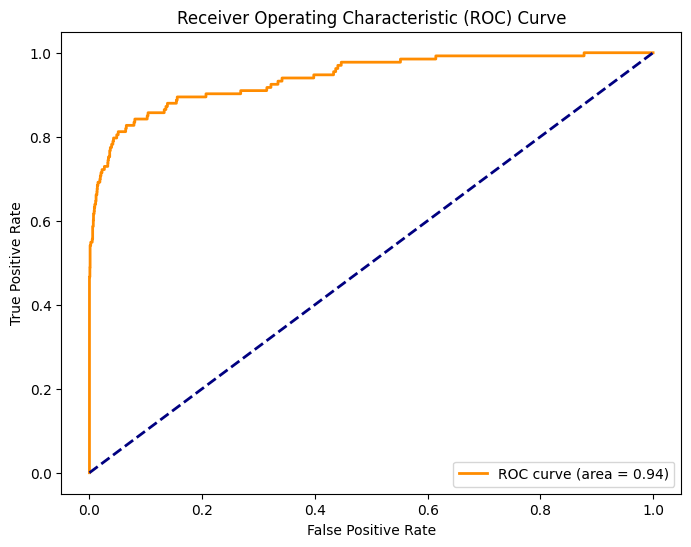

In [119]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Assuming ensemble_model is already defined and trained as in your code

# Predict probabilities for the test set
y_pred_prob_ensemble = ensemble_model.predict_proba(X_test_combined)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_ensemble)
print(f"\nEnsemble Model Test Set ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ensemble)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Labeling the Unlabeled Data

In [120]:
df_unlabeled = pd.read_csv("/kaggle/input/model-data/preprocessed_dataset_13-12-2023.csv")
print(f"Raw Data Shape: {df_unlabeled.shape}")
df_unlabeled.head()

Raw Data Shape: (34807, 15)


,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...,30000.0,35000.0,NaN,entry_level,NaN,NaN,NaN,NaN,NaN,NaN
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...,130000.0,160000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...,54000.0,82000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...,52000.0,81000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...,57000.0,131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
df_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34807 entries, 0 to 34806
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   site             34807 non-null  object 
 1   role             34807 non-null  object 
 2   company_name     34652 non-null  object 
 3   location         34478 non-null  object 
 4   job_description  32421 non-null  object 
 5   min_salary       14250 non-null  float64
 6   max_salary       14250 non-null  float64
 7   ratings          3878 non-null   float64
 8   job_level        13186 non-null  object 
 9   Search_Keywords  1208 non-null   object 
 10  Search_Location  1208 non-null   object 
 11  Job_Detail_Link  1208 non-null   object 
 12  Post_Time        1208 non-null   object 
 13  Current_Time     1208 non-null   object 
 14  job_type         626 non-null    object 
dtypes: float64(3), object(12)
memory usage: 4.0+ MB


In [122]:
df_unlabeled.describe(include = "all")

,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
count,34807,34807,34652,34478,32421,1.425000e+04,1.425000e+04,3878.000000,13186,1208,1208,1208,1208,1208,626
unique,3,13519,13574,4974,28560,NaN,NaN,NaN,5,1,1,990,89,1,9
top,glassdoor,data analyst,tiktok,remote,aipowered robotic technology platform symbotic...,NaN,NaN,NaN,Unknown,data scientist,united states,https://www.indeed.com/rc/clk?jk=ab50cfa59689a...,posted posted 30+ days ago,2023-11-14,not available
freq,21571,4176,222,1414,49,NaN,NaN,NaN,7282,1208,1208,3,233,1208,435
mean,NaN,NaN,NaN,NaN,NaN,2.252753e+09,2.333653e+09,3.990330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.643616e+10,3.691536e+10,0.451955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.400000e+01,1.600000e+01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,4.500000e+04,6.075900e+04,3.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,6.500000e+04,9.200000e+04,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,8.400000e+04,1.180000e+05,4.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
df_unlabeled.describe(exclude="object")

,min_salary,max_salary,ratings
count,1.425000e+04,1.425000e+04,3878.000000
mean,2.252753e+09,2.333653e+09,3.990330
std,3.643616e+10,3.691536e+10,0.451955
min,1.400000e+01,1.600000e+01,1.000000
25%,4.500000e+04,6.075900e+04,3.800000
50%,6.500000e+04,9.200000e+04,4.000000
75%,8.400000e+04,1.180000e+05,4.200000
max,1.188475e+12,1.140456e+12,5.000000


In [124]:
df_unlabeled.describe(exclude=np.number)

,site,role,company_name,location,job_description,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
count,34807,34807,34652,34478,32421,13186,1208,1208,1208,1208,1208,626
unique,3,13519,13574,4974,28560,5,1,1,990,89,1,9
top,glassdoor,data analyst,tiktok,remote,aipowered robotic technology platform symbotic...,Unknown,data scientist,united states,https://www.indeed.com/rc/clk?jk=ab50cfa59689a...,posted posted 30+ days ago,2023-11-14,not available
freq,21571,4176,222,1414,49,7282,1208,1208,3,233,1208,435


There are many missing feature values, we will perform futhur checks

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">Data Checks to perform </p>
 - Check Missing values
 - Check Duplicates
 - Check data type
 - Check the number of unique values of each column
 - Check statistics of data set
 - Check various categories present in the different categorical column

 #### Missing values

In [125]:
df_unlabeled.isnull().sum()

site                   0
role                   0
company_name         155
location             329
job_description     2386
min_salary         20557
max_salary         20557
ratings            30929
job_level          21621
Search_Keywords    33599
Search_Location    33599
Job_Detail_Link    33599
Post_Time          33599
Current_Time       33599
job_type           34181
dtype: int64

In [126]:
## Here we will check the percentage of nan values present in each feature
feature_na = [feature for feature in df_unlabeled.columns if df_unlabeled[feature].isnull().sum() > 0 ]

for feature in feature_na:
    print(feature, np.round(df_unlabeled[feature].isnull().mean() * 100,4), " % missing")

company_name 0.4453  % missing
location 0.9452  % missing
job_description 6.8549  % missing
min_salary 59.06  % missing
max_salary 59.06  % missing
ratings 88.8586  % missing
job_level 62.1168  % missing
Search_Keywords 96.5294  % missing
Search_Location 96.5294  % missing
Job_Detail_Link 96.5294  % missing
Post_Time 96.5294  % missing
Current_Time 96.5294  % missing
job_type 98.2015  % missing


In [127]:
# Null valuse more than 10%
columns_with_null_values_total = (df_unlabeled.isnull().sum() / len(df_unlabeled)) * 100
columns_with_null_values_percentage = columns_with_null_values_total[columns_with_null_values_total > 10].sort_values(ascending=False)

columns_with_null_values_percentage

job_type           98.201511
Search_Keywords    96.529434
Search_Location    96.529434
Job_Detail_Link    96.529434
Post_Time          96.529434
Current_Time       96.529434
ratings            88.858563
job_level          62.116816
min_salary         59.059959
max_salary         59.059959
dtype: float64

<b>observation:</b> There are many missing feature values. There 8 features with ~85% values are null and 2 features with ~65% null.

The feature with 50% null values can be removed from the dataset

In [128]:
df_unlabeled.drop(columns_with_null_values_percentage.keys().tolist(),axis=1,inplace=True)

df_unlabeled.head()

,site,role,company_name,location,job_description
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...


In [129]:
df_unlabeled.columns

Index(['site', 'role', 'company_name', 'location', 'job_description'], dtype='object')

In [130]:
df_unlabeled.drop(columns=['site','company_name'],inplace = True)

In [131]:
df_unlabeled.head()

,role,location,job_description
0,data analyst data entry,remote,juristat building innovative suite products ne...
1,business systems analyst,new york ny,join azad technology partners business systems...
2,data analyst,lincoln ne,haberfeld align marketing products people sust...
3,data analysis charlotte corporate location,charlotte nc,data analyst collect customer requirements det...
4,data science graduate,spring tx,data science graduate role designated edge mea...


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Duplicate Values Check </p>

In [132]:
df_unlabeled.duplicated().sum()

2371

In [133]:
print("***** Duplicate check Feature wise *****\n")

# Check Job description duplications
print("job_description: ", df_unlabeled["job_description"].duplicated().sum())

***** Duplicate check Feature wise *****

job_description:  6246


There are duplicated records, this has to taken care during preprocessing stage

In [134]:
#Sorting data according to text in ascending order
sorted_data_unlabeled=df_unlabeled.sort_values('job_description', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_data_unlabeled[sorted_data_unlabeled["job_description"].duplicated()]

,role,location,job_description
24532,data scientist,seattle wa,_dla piper equal opportunity employer qualifie...
24183,data scientist,los angeles ca,_dla piper equal opportunity employer qualifie...
24244,data scientist,houston tx,_dla piper equal opportunity employer qualifie...
25019,data scientist,philadelphia pa,_dla piper equal opportunity employer qualifie...
23497,data scientist,dallas tx,_dla piper equal opportunity employer qualifie...
...,...,...,...
19369,statistician intermediate,thompson street ann arbor mi,NaN
19383,nlp natural language processing product manager,austin tx,NaN
19385,artificial intelligence developer,washington dc,NaN
19396,ai machine learning algorithms architect resea...,santa clara ca,NaN


In [135]:
df_unlabeled.shape

(34807, 3)

#### Check the Feature Uniqueness

In [136]:
for feature in df_unlabeled.columns:
    print('{}: Unique Count: {}\n {}\n'.format(feature, len(df_unlabeled[feature].unique()), df_unlabeled[feature].unique()))

role: Unique Count: 13519
 ['data analyst data entry' 'business systems analyst' 'data analyst' ...
 'exploitation analyst tssci w fs poly'
 'russian lang analystactive tssci clearance required'
 'programfinancial analyst']

location: Unique Count: 4975
 ['remote' 'new york ny' 'lincoln ne' ... 'montréal'
 'base camp toronto canada' 'kitchener']

job_description: Unique Count: 28561
 ['juristat building innovative suite products need team create tools seeking highly motivated organized individual join data team data analyst team responsible acquiring analyzing complete accurate data available grow products inform business strategies particular team member responsible analyzing incoming legal documents realtime detect correct errors processing enter data source documents templates annotate legal documents provide feedback others improve proprietary artificial intelligence role remote workfromhome possess high attention detail strong work ethic job position responsibilities include colle

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Data preprocessing </p>

<b>Handle Missing Values</b>

In [137]:
df_unlabeled.isnull().sum()

role                  0
location            329
job_description    2386
dtype: int64

In [138]:
# Fill na values with missing

for feature in df_unlabeled.columns:
  if(df_unlabeled[feature].isnull().sum()>0):
    df_unlabeled[feature].fillna("missing", inplace=True)

df_unlabeled.isnull().sum()

role               0
location           0
job_description    0
dtype: int64

<b>Deduplication of data</b>

In [139]:
df_unlabeled.duplicated().sum()

2371

In [140]:
df_unlabeled.drop_duplicates(keep="first", inplace= True)
print("Shape: ", df_unlabeled.shape)

df_unlabeled.duplicated().sum()

Shape:  (32436, 3)


0

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Exploratory Data Analysis </p>

#### Description: Analyze the count of Charecters, Words, and Sentences in each segment

In [141]:
# No. of charecters in Job Description
df_unlabeled['desc_num_char'] = df_unlabeled['job_description'].apply(len)

# No. of of words in Job Description
df_unlabeled['desc_num_words'] = df_unlabeled['job_description'].apply(lambda x:len(nltk.word_tokenize(x)))

# No. of of sentences in Job Description
df_unlabeled['desc_num_sent'] = df_unlabeled['job_description'].apply(lambda x:len(nltk.sent_tokenize(x)))

df_unlabeled.head()

,role,location,job_description,desc_num_char,desc_num_words,desc_num_sent
0,data analyst data entry,remote,juristat building innovative suite products ne...,4309,542,1
1,business systems analyst,new york ny,join azad technology partners business systems...,603,70,1
2,data analyst,lincoln ne,haberfeld align marketing products people sust...,2190,276,1
3,data analysis charlotte corporate location,charlotte nc,data analyst collect customer requirements det...,943,119,1
4,data science graduate,spring tx,data science graduate role designated edge mea...,5391,675,1


In [142]:
df_unlabeled.describe(include=np.number)

,desc_num_char,desc_num_words,desc_num_sent
count,32436.000000,32436.000000,32436.0
mean,2520.224812,296.595912,1.0
std,2076.809849,242.021956,0.0
min,1.000000,1.000000,1.0
25%,725.000000,88.000000,1.0
50%,2272.000000,268.000000,1.0
75%,3734.000000,439.000000,1.0
max,31300.000000,3753.000000,1.0


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Text preprocessing </p>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative type

In [143]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopWords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [144]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess(corpus):
    preprocessed = []
    for sentance in tqdm(corpus):
        #sentance = re.sub(r"http+", "", sentance)
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopWords)
        #sentence = ' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english'))
        #preprocessed.append(sentance.strip())
        preprocessed.append(' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english')))

    return preprocessed

In [145]:
df_unlabeled.sample(5)

,role,location,job_description,desc_num_char,desc_num_words,desc_num_sent
16199,data analytics ml developer,syracuse ny downtown area,missing,7,1,1
28341,data analyst,remote,mntn weve built culture based quality trust am...,2939,349,1
6785,business data analyst,los angeles ca,position business data analyst supervisor mana...,5390,638,1
24356,machine learning engineer,goodlettsville tn,company overview dollar general corporation de...,3094,360,1
3732,python developer,bengaluru,requirements experience years python scripting...,374,46,1


In [146]:
df_unlabeled.dtypes

role               object
location           object
job_description    object
desc_num_char       int64
desc_num_words      int64
desc_num_sent       int64
dtype: object

In [147]:
%%time

df_unlabeled["desc_transformed"] = preprocess(df_unlabeled['job_description'].values)
#df["site_transformed"] = preprocess(df['site'].values)
#df["role_transformed"] = preprocess(df['role'].values)
#df["comp_transformed"] = preprocess(df['company_name'].values)
#df["loc_transformed"] = preprocess(df['location'].values)


df_unlabeled["desc_transformed"][:5]

100%|██████████| 32436/32436 [26:37<00:00, 20.31it/s]  

CPU times: user 23min 27s, sys: 3min 10s, total: 26min 37s
Wall time: 26min 37s


0    juristat building innovative suite products ne...
1    join azad technology partners business systems...
2    haberfeld align marketing products people sust...
3    data analyst collect customer requirements det...
4    data science graduate role designated edge mea...
Name: desc_transformed, dtype: object

In [148]:
df_unlabeled.head()

,role,location,job_description,desc_num_char,desc_num_words,desc_num_sent,desc_transformed
0,data analyst data entry,remote,juristat building innovative suite products ne...,4309,542,1,juristat building innovative suite products ne...
1,business systems analyst,new york ny,join azad technology partners business systems...,603,70,1,join azad technology partners business systems...
2,data analyst,lincoln ne,haberfeld align marketing products people sust...,2190,276,1,haberfeld align marketing products people sust...
3,data analysis charlotte corporate location,charlotte nc,data analyst collect customer requirements det...,943,119,1,data analyst collect customer requirements det...
4,data science graduate,spring tx,data science graduate role designated edge mea...,5391,675,1,data science graduate role designated edge mea...


In [149]:
%%time
#OPTIMIZED
# Function to calculate sentiment scores for a single row
def calculate_sentiment_scores(row):
    tokens = word_tokenize(row['desc_transformed'])
    positive_score = np.sum(np.isin(tokens, list(positive_words)))
    negative_score = np.sum(np.isin(tokens, list(negative_words)))
    return positive_score, negative_score

# Convert Pandas DataFrame to a list of dictionaries
data_for_parallel_unlabeled = df_unlabeled[['desc_transformed']].to_dict('records')

# Calculate sentiment scores using parallel processing
with ProcessPoolExecutor() as executor:
    sentiment_scores_unlabeled = list(executor.map(calculate_sentiment_scores, data_for_parallel_unlabeled))

# Assign sentiment scores to the DataFrame
df_unlabeled[['positive_score', 'negative_score']] = np.array(sentiment_scores_unlabeled)

# Display the DataFrame with new sentiment score columns
print(df_unlabeled[['desc_transformed', 'positive_score', 'negative_score']])

                                        desc_transformed  positive_score  \
0      juristat building innovative suite products ne...              60   
1      join azad technology partners business systems...               5   
2      haberfeld align marketing products people sust...              27   
3      data analyst collect customer requirements det...               4   
4      data science graduate role designated edge mea...              64   
...                                                  ...             ...   
34802  pala interactiveis fullservice real money soci...              16   
34803  date posted hiring organization rose internati...              32   
34804  brock solutions innovative engineering solutio...              36   
34805  join urbanlogiq data empowers communities urba...              46   
34806  java developer full stack contract duration mo...               6   

       negative_score  
0                   9  
1                   0  
2              

In [150]:
df_unlabeled.head()

,role,location,job_description,desc_num_char,desc_num_words,desc_num_sent,desc_transformed,positive_score,negative_score
0,data analyst data entry,remote,juristat building innovative suite products ne...,4309,542,1,juristat building innovative suite products ne...,60,9
1,business systems analyst,new york ny,join azad technology partners business systems...,603,70,1,join azad technology partners business systems...,5,0
2,data analyst,lincoln ne,haberfeld align marketing products people sust...,2190,276,1,haberfeld align marketing products people sust...,27,3
3,data analysis charlotte corporate location,charlotte nc,data analyst collect customer requirements det...,943,119,1,data analyst collect customer requirements det...,4,4
4,data science graduate,spring tx,data science graduate role designated edge mea...,5391,675,1,data science graduate role designated edge mea...,64,8


In [151]:
df_unlabeled_score = df_unlabeled.copy()

In [152]:
df_unlabeled_score.to_csv("Processed_data_score.csv", index=False)

In [189]:
df_unlabeled = pd.read_csv("/kaggle/input/model-data/Processed_data_score.csv")

In [190]:
df_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32436 entries, 0 to 32435
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              32436 non-null  object
 1   location          32436 non-null  object
 2   job_description   32436 non-null  object
 3   desc_num_char     32436 non-null  int64 
 4   desc_num_words    32436 non-null  int64 
 5   desc_num_sent     32436 non-null  int64 
 6   desc_transformed  32435 non-null  object
 7   positive_score    32436 non-null  int64 
 8   negative_score    32436 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 2.2+ MB


In [191]:
# Fill missing value in 'desc_transformed' with an empty string
df_unlabeled['desc_transformed'].fillna('', inplace=True)

In [192]:
# Assuming unlabeled_df has 'desc_transformed', 'positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent' columns
# If needed, fill any missing values in unlabeled_df
df_unlabeled = df_unlabeled.fillna('')

# Extract features from unlabeled data
X_text_unlabeled = df_unlabeled['desc_transformed']
X_numeric_unlabeled = df_unlabeled[['positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent']]

# TF-IDF vectorization for text data
X_text_unlabeled_tfidf = tfidf_vectorizer.transform(X_text_unlabeled)

# Combine text TF-IDF vectors with numeric features
X_unlabeled_combined = pd.concat([
    X_numeric_unlabeled.reset_index(drop=True),
    pd.DataFrame(X_text_unlabeled_tfidf.toarray())
], axis=1)

# Standardize numeric features
X_unlabeled_combined.iloc[:, :5] = scaler.transform(X_unlabeled_combined.iloc[:, :5])

# Apply Min-Max scaling to numeric features
X_unlabeled_combined[numeric_columns] = min_max_scaler.transform(X_unlabeled_combined[numeric_columns])

# Convert feature names to strings
X_unlabeled_combined.columns = X_unlabeled_combined.columns.astype(str)

# Predict probabilities for unlabeled data using the ensemble model
y_pred_prob_unlabeled = ensemble_model.predict_proba(X_unlabeled_combined)[:, 1]

# Apply custom threshold
custom_threshold_unlabeled = 0.5  # Adjust this threshold based on your requirements
y_pred_unlabeled = (y_pred_prob_unlabeled > custom_threshold_unlabeled).astype(int)

# Add the predicted labels to the unlabeled DataFrame
df_unlabeled['predicted_fraudulent'] = y_pred_unlabeled

# Display or save the labeled unlabeled data
print(df_unlabeled[['desc_transformed', 'positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent', 'predicted_fraudulent']])


                                        desc_transformed  positive_score  \
0      juristat building innovative suite products ne...              60   
1      join azad technology partners business systems...               5   
2      haberfeld align marketing products people sust...              27   
3      data analyst collect customer requirements det...               4   
4      data science graduate role designated edge mea...              64   
...                                                  ...             ...   
32431  pala interactiveis fullservice real money soci...              16   
32432  date posted hiring organization rose internati...              32   
32433  brock solutions innovative engineering solutio...              36   
32434  join urbanlogiq data empowers communities urba...              46   
32435  java developer full stack contract duration mo...               6   

       negative_score  desc_num_char  desc_num_words  desc_num_sent  \
0               

In [193]:
df_unlabeled.head()

,role,location,job_description,desc_num_char,desc_num_words,desc_num_sent,desc_transformed,positive_score,negative_score,predicted_fraudulent
0,data analyst data entry,remote,juristat building innovative suite products ne...,4309,542,1,juristat building innovative suite products ne...,60,9,0
1,business systems analyst,new york ny,join azad technology partners business systems...,603,70,1,join azad technology partners business systems...,5,0,0
2,data analyst,lincoln ne,haberfeld align marketing products people sust...,2190,276,1,haberfeld align marketing products people sust...,27,3,0
3,data analysis charlotte corporate location,charlotte nc,data analyst collect customer requirements det...,943,119,1,data analyst collect customer requirements det...,4,4,0
4,data science graduate,spring tx,data science graduate role designated edge mea...,5391,675,1,data science graduate role designated edge mea...,64,8,0


In [194]:
df_unlabeled["predicted_fraudulent"].value_counts()

predicted_fraudulent
0    31423
1     1013
Name: count, dtype: int64

In [195]:
df_unlabeled.to_csv("Processed_data_labelled.csv", index=False)

In [196]:
df_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32436 entries, 0 to 32435
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   role                  32436 non-null  object
 1   location              32436 non-null  object
 2   job_description       32436 non-null  object
 3   desc_num_char         32436 non-null  int64 
 4   desc_num_words        32436 non-null  int64 
 5   desc_num_sent         32436 non-null  int64 
 6   desc_transformed      32436 non-null  object
 7   positive_score        32436 non-null  int64 
 8   negative_score        32436 non-null  int64 
 9   predicted_fraudulent  32436 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 2.5+ MB


In [197]:
df_unlabeled=df_unlabeled.rename(columns = {'predicted_fraudulent':'fraudulent'})

In [198]:
df_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32436 entries, 0 to 32435
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              32436 non-null  object
 1   location          32436 non-null  object
 2   job_description   32436 non-null  object
 3   desc_num_char     32436 non-null  int64 
 4   desc_num_words    32436 non-null  int64 
 5   desc_num_sent     32436 non-null  int64 
 6   desc_transformed  32436 non-null  object
 7   positive_score    32436 non-null  int64 
 8   negative_score    32436 non-null  int64 
 9   fraudulent        32436 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 2.5+ MB


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13894 entries, 749 to 15795
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              13894 non-null  object
 1   location          13894 non-null  object
 2   job_description   13894 non-null  object
 3   fraudulent        13894 non-null  int64 
 4   desc_num_char     13894 non-null  int64 
 5   desc_num_words    13894 non-null  int64 
 6   desc_num_sent     13894 non-null  int64 
 7   desc_transformed  13894 non-null  object
 8   positive_score    13894 non-null  int64 
 9   negative_score    13894 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 1.2+ MB


# Combing both Exisitng and new scrapped labeled data

In [200]:
df_combined = pd.concat([df, df_unlabeled], ignore_index=True)

In [201]:
df_combined.head()

,role,location,job_description,fraudulent,desc_num_char,desc_num_words,desc_num_sent,desc_transformed,positive_score,negative_score
0,Data Analyst,"GB, LND, London",We are looking for a Data Analyst to join our ...,0,414,70,2,looking data analyst join growing team develop...,3,0
1,Estimator,"US, WI, Kenosha","As a Estimator, you will provide assistance to...",0,1282,188,2,estimator provide assistance customers purchas...,5,1
2,Lead QA Engineer,"US, CA, El Segundo",ConsumerTrack is a rapidly growing internet ma...,0,1965,313,8,consumertrack rapidly growing internet marketi...,14,2
3,Community Management Assistant,missing,"FunctionResponsible for reception, corresponde...",0,472,67,1,functionresponsible reception correspondence a...,7,0
4,Android Developer (Kit Kat Kruncher),"SG, ,",Been to the doctor lately? Ever thought it odd...,0,2102,430,15,doctor lately ever thought odd experience almo...,20,11


In [202]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46330 entries, 0 to 46329
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              46330 non-null  object
 1   location          46330 non-null  object
 2   job_description   46330 non-null  object
 3   fraudulent        46330 non-null  int64 
 4   desc_num_char     46330 non-null  int64 
 5   desc_num_words    46330 non-null  int64 
 6   desc_num_sent     46330 non-null  int64 
 7   desc_transformed  46330 non-null  object
 8   positive_score    46330 non-null  int64 
 9   negative_score    46330 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 3.5+ MB


In [203]:
df_combined.to_csv("combined_data_labelled.csv", index=False)

In [204]:
df_combined = pd.read_csv("/kaggle/working/combined_data_labelled.csv")

In [206]:
df_combined.head()

,role,location,job_description,fraudulent,desc_num_char,desc_num_words,desc_num_sent,desc_transformed,positive_score,negative_score
0,Data Analyst,"GB, LND, London",We are looking for a Data Analyst to join our ...,0,414,70,2,looking data analyst join growing team develop...,3,0
1,Estimator,"US, WI, Kenosha","As a Estimator, you will provide assistance to...",0,1282,188,2,estimator provide assistance customers purchas...,5,1
2,Lead QA Engineer,"US, CA, El Segundo",ConsumerTrack is a rapidly growing internet ma...,0,1965,313,8,consumertrack rapidly growing internet marketi...,14,2
3,Community Management Assistant,missing,"FunctionResponsible for reception, corresponde...",0,472,67,1,functionresponsible reception correspondence a...,7,0
4,Android Developer (Kit Kat Kruncher),"SG, ,",Been to the doctor lately? Ever thought it odd...,0,2102,430,15,doctor lately ever thought odd experience almo...,20,11


# Retraining the model on combined data

In [207]:
custom_threshold

0.3

In [209]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46330 entries, 0 to 46329
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              46330 non-null  object
 1   location          46330 non-null  object
 2   job_description   46330 non-null  object
 3   fraudulent        46330 non-null  int64 
 4   desc_num_char     46330 non-null  int64 
 5   desc_num_words    46330 non-null  int64 
 6   desc_num_sent     46330 non-null  int64 
 7   desc_transformed  46330 non-null  object
 8   positive_score    46330 non-null  int64 
 9   negative_score    46330 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 3.5+ MB


In [210]:
df_combined.fillna('', inplace=True)

In [212]:
# Assuming df_combined has 'desc_transformed', 'positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent', 'fraudulent' columns
# If needed, fill any missing values in df_combined
df_combined = pd.concat([df, df_unlabeled], ignore_index=True).fillna('')

# Extract features and labels from combined data
X_text_combined_all = df_combined['desc_transformed']
X_numeric_combined_all = df_combined[['positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent']]
y_combined_all = df_combined['fraudulent']

# TF-IDF vectorization for text data
X_text_combined_all_tfidf = tfidf_vectorizer.transform(X_text_combined_all)

# Combine text TF-IDF vectors with numeric features
X_combined_all = pd.concat([
    X_numeric_combined_all.reset_index(drop=True),
    pd.DataFrame(X_text_combined_all_tfidf.toarray())
], axis=1)

# Standardize numeric features
X_combined_all.iloc[:, :5] = scaler.transform(X_combined_all.iloc[:, :5])

# Apply Min-Max scaling to numeric features
X_combined_all[numeric_columns] = min_max_scaler.transform(X_combined_all[numeric_columns])

# Convert feature names to strings
X_combined_all.columns = X_combined_all.columns.astype(str)

# Apply SMOTE to balance the combined data
smote_combined = SMOTE(random_state=42)
X_combined_resampled, y_combined_resampled = smote_combined.fit_resample(X_combined_all, y_combined_all)

# Retrain the ensemble model on the combined and resampled data
ensemble_model.fit(X_combined_resampled, y_combined_resampled)

# Print metrics for the retrained ensemble model on the combined data (optional)
y_pred_prob_combined_all = ensemble_model.predict_proba(X_combined_all)[:, 1]
y_pred_combined_all = (y_pred_prob_combined_all > custom_threshold).astype(int)

print("\nRetrained Ensemble Model Metrics on Combined Data:")
print(f"Accuracy: {accuracy_score(y_combined_all, y_pred_combined_all)}")
print(f"Precision: {precision_score(y_combined_all, y_pred_combined_all)}")
print(f"Recall: {recall_score(y_combined_all, y_pred_combined_all)}")
print(f"F1: {f1_score(y_combined_all, y_pred_combined_all)}")



Retrained Ensemble Model Metrics on Combined Data:
Accuracy: 0.9899848909993525
Precision: 0.7835437120149603
Recall: 0.9994036970781157
F1: 0.8784067085953878



Confusion Matrix:
[[44190   463]
 [    1  1676]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     44653
           1       0.78      1.00      0.88      1677

    accuracy                           0.99     46330
   macro avg       0.89      0.99      0.94     46330
weighted avg       0.99      0.99      0.99     46330


ROC AUC: 0.9995807664484317


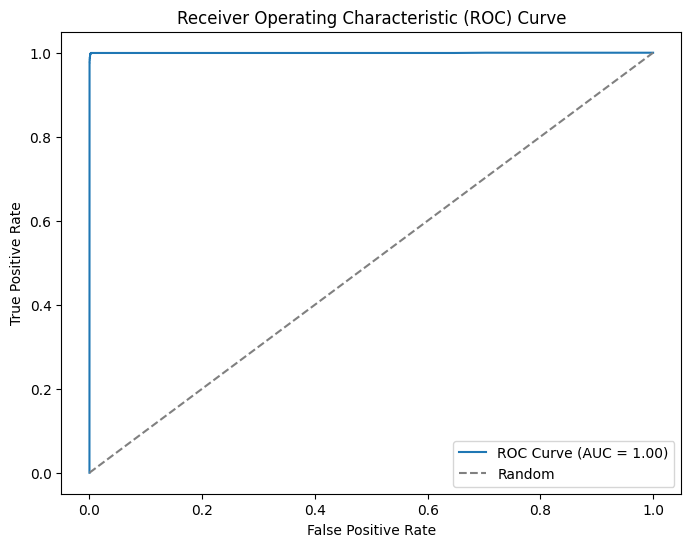

In [213]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_combined_all, y_pred_combined_all)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
print("\nClassification Report:")
print(classification_report(y_combined_all, y_pred_combined_all))

# ROC AUC
roc_auc = roc_auc_score(y_combined_all, y_pred_prob_combined_all)
print(f"\nROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_combined_all, y_pred_prob_combined_all)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [174]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46330 entries, 0 to 46329
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              46330 non-null  object
 1   location          46330 non-null  object
 2   job_description   46330 non-null  object
 3   fraudulent        46330 non-null  int64 
 4   desc_num_char     46330 non-null  int64 
 5   desc_num_words    46330 non-null  int64 
 6   desc_num_sent     46330 non-null  int64 
 7   desc_transformed  46330 non-null  object
 8   positive_score    46330 non-null  int64 
 9   negative_score    46330 non-null  int64 
 10  predicted_label   46330 non-null  object
dtypes: int64(6), object(5)
memory usage: 3.9+ MB


In [175]:
df_combined['fraudulent'].value_counts()

fraudulent
0    44666
1     1664
Name: count, dtype: int64

# Testing on unseen test data

In [222]:
df_test_data = pd.read_csv('/kaggle/working/test_data.csv')

In [223]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   role              3474 non-null   object
 1   location          3474 non-null   object
 2   job_description   3474 non-null   object
 3   fraudulent        3474 non-null   int64 
 4   desc_num_char     3474 non-null   int64 
 5   desc_num_words    3474 non-null   int64 
 6   desc_num_sent     3474 non-null   int64 
 7   desc_transformed  3474 non-null   object
 8   positive_score    3474 non-null   int64 
 9   negative_score    3474 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 271.5+ KB


In [224]:
df_test['fraudulent'].value_counts()

fraudulent
0    3322
1     152
Name: count, dtype: int64

In [229]:
# Assuming df_test_data has 'desc_transformed', 'positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent', 'fraudulent' columns
# If needed, fill any missing values in df_test_data
df_test_data = df_test_data.fillna('')

# Extract features and labels from the test data
X_text_test_data = df_test_data['desc_transformed']
X_numeric_test_data = df_test_data[['positive_score', 'negative_score', 'desc_num_char', 'desc_num_words', 'desc_num_sent']]
y_test_data = df_test_data['fraudulent']

# TF-IDF vectorization for text data
X_text_test_data_tfidf = tfidf_vectorizer.transform(X_text_test_data)

# Combine text TF-IDF vectors with numeric features
X_test_data = pd.concat([
    X_numeric_test_data.reset_index(drop=True),
    pd.DataFrame(X_text_test_data_tfidf.toarray())
], axis=1)

# Standardize numeric features
X_test_data.iloc[:, :5] = scaler.transform(X_test_data.iloc[:, :5])

# Apply Min-Max scaling to numeric features
X_test_data[numeric_columns] = min_max_scaler.transform(X_test_data[numeric_columns])

# Convert feature names to strings
X_test_data.columns = X_test_data.columns.astype(str)

# Predict probabilities for the test data using the retrained ensemble model
y_pred_prob_test_data = ensemble_model.predict_proba(X_test_data)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_data, y_pred_prob_test_data)

# Find the threshold that maximizes the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Apply the optimal threshold
y_pred_optimal_threshold = (y_pred_prob_test_data > optimal_threshold).astype(int)

# Print metrics for the test data using the optimal threshold
print("\nTest Data Metrics with Optimal Threshold:")
print(f"Accuracy: {accuracy_score(y_test_data, y_pred_optimal_threshold)}")
print(f"Precision: {precision_score(y_test_data, y_pred_optimal_threshold)}")
print(f"Recall: {recall_score(y_test_data, y_pred_optimal_threshold)}")
print(f"F1: {f1_score(y_test_data, y_pred_optimal_threshold)}")

# Confusion matrix for the test data with optimal threshold
conf_matrix_optimal_threshold = confusion_matrix(y_test_data, y_pred_optimal_threshold)
print("\nTest Data Confusion Matrix with Optimal Threshold:")
print(conf_matrix_optimal_threshold)

# Classification report for the test data with optimal threshold
classification_report_optimal_threshold = classification_report(y_test_data, y_pred_optimal_threshold, target_names=["Real", "Fake"])
print("\nTest Data Classification Report with Optimal Threshold:")
print(classification_report_optimal_threshold)




Test Data Metrics with Optimal Threshold:
Accuracy: 0.9761082325849165
Precision: 0.8349514563106796
Recall: 0.5657894736842105
F1: 0.6745098039215686

Test Data Confusion Matrix with Optimal Threshold:
[[3305   17]
 [  66   86]]

Test Data Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      3322
        Fake       0.83      0.57      0.67       152

    accuracy                           0.98      3474
   macro avg       0.91      0.78      0.83      3474
weighted avg       0.97      0.98      0.97      3474

